In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1488]:
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression
from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite, bandpass_velocity, interp_in_space, integral, compute_ape
from qc import qc_turbulence, qc_velocity

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [1508]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
raw = raw.resample(time='1H').interpolate("linear")

In [1509]:
# need to relax the qc criteria a bit because of heaving due to larger surface gravity waves
raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1)
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))

In [1511]:
dsp.get_sampling_step(raw, dim='time')*1e-9

3600.0

In [1512]:
# bandpass between low*f and high*f
f = gsw.f(40.7)
raw = bandpass_velocity(raw, 0.9*f, 1.1*f)

0.6847454234948632
0.616270881145377
0.7532199658443496


In [1513]:
raw = raw.sel(time=slice('2016-10-01','2016-10-21'))
cfs = cfs.sel(time=slice('2016-10-01','2016-10-21'))

## Horizontal kinetic energy (HKE)

In [1514]:
mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)

In [1515]:
rho0=raw.rho0.mean()
raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2) # that gonna be in [J m^{-3}]
raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)

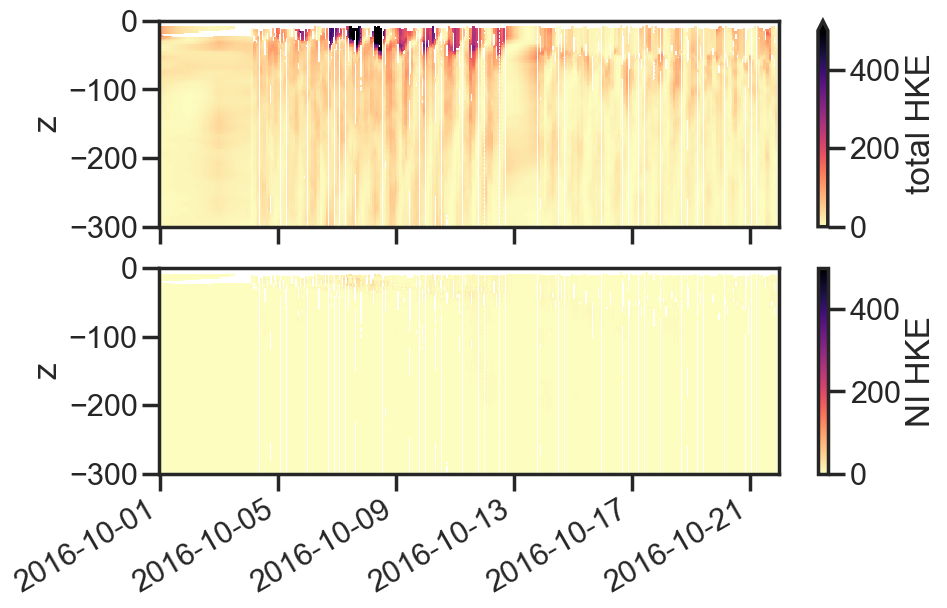

In [1516]:
zmin = -300
f, (ax0, ax1) = plt.subplots(2,1,figsize=(10,6), sharex=True) 
raw.hkeTOT.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax0, cbar_kwargs={'label': 'total HKE'})
ax0.set_ylim(zmin,0)
ax0.set_xlabel(None)

raw.hkeNI.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax1, cbar_kwargs={'label': 'NI HKE'})
ax1.set_ylim(zmin,0)
ax1.set_xlabel(None);

In [1517]:
from scipy import signal
import xrscipy.signal as dsp

In [1518]:
dfu = dsp.spectrogram(raw.u.dropna('z', how='all').dropna('z', how='all'), dim='time', fs=86400/dsp.get_sampling_step(raw, dim='time') )
dfv = dsp.spectrogram(raw.v.dropna('z', how='all').dropna('z', how='all'), dim='time', fs=86400/dsp.get_sampling_step(raw, dim='time') )
dft = 0.5*(dfu+dfv)

TypeError: '<' not supported between instances of 'float' and 'Timestamp'

AttributeError: 'Rectangle' object has no property 'cmap'

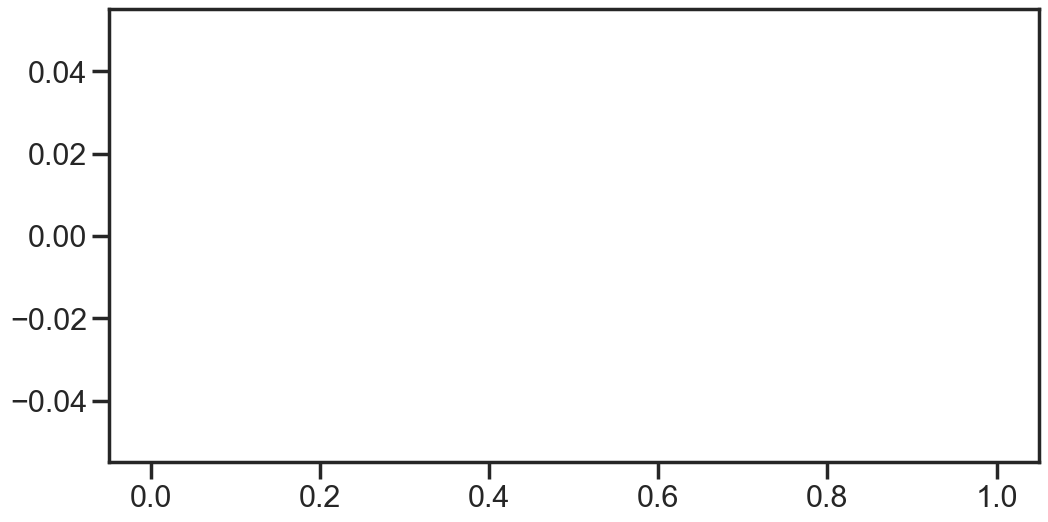

In [1506]:
# df = dsp.spectrogram(raw.u.dropna('z', how='all').dropna('z', how='all'), dim='dtime', fs=86400/dsp.get_sampling_step(raw, dim='dtime') )
# dfni['frequency'] = dfni.frequency*1e-9*86400
dft.pipe(np.log10).plot(cmap='viridis', vmin=-5, vmax=-1)
plt.ylim(-400,-30)
plt.xlim(1e-1,6e0)
plt.title(None);
plt.xlabel('$\omega$ [cpd]')
plt.xscale('log')

In [1331]:
dfniu = dsp.spectrogram(raw.uNI.dropna('z', how='all').dropna('z', how='all'), dim='dtime', fs=86400/dsp.get_sampling_step(raw, dim='dtime') )
dfniv = dsp.spectrogram(raw.vNI.dropna('z', how='all').dropna('z', how='all'), dim='dtime', fs=86400/dsp.get_sampling_step(raw, dim='dtime') )
dfnit = 0.5* (dfniu+dfniv)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UnevenSamplingWarning: Average sampling 7.07e+03 != first sampling step 8.83e+04
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 245, using nperseg = 245
  .format(nperseg, input_length))
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UnevenSamplingWarning: Average sampling 7.07e+03 != first sampling step 8.83e+04
  
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 245, using nperseg = 245
  .format(nperseg, input_length))


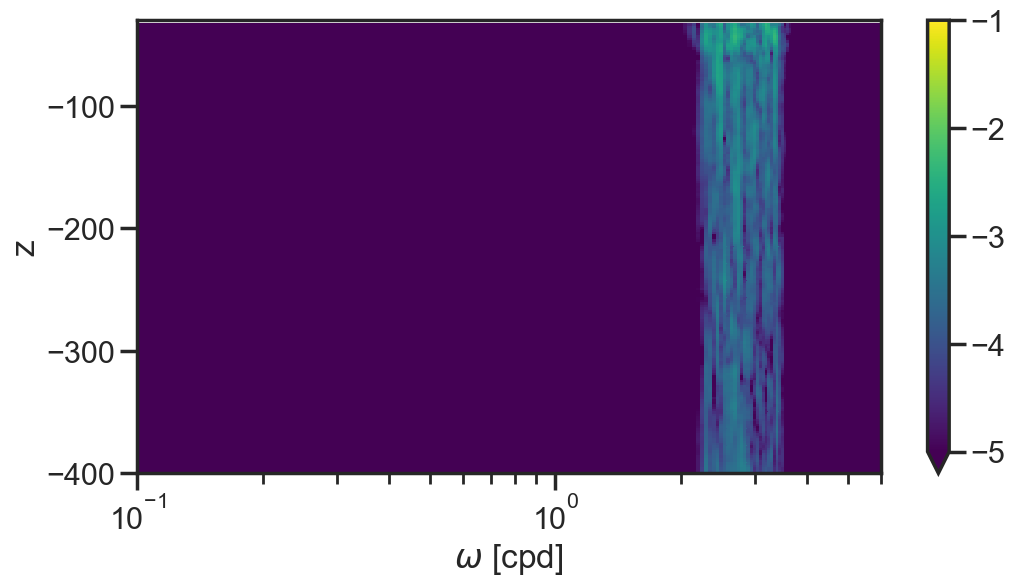

In [1332]:
# dfni = dsp.spectrogram(raw.uNI.dropna('z', how='all').dropna('z', how='all'), dim='dtime', fs=86400/dsp.get_sampling_step(raw, dim='dtime') )
# dfni['frequency'] = dfni.frequency*1e-9*86400
dfnit.pipe(np.log10).plot(cmap='viridis', vmin=-5, vmax=-1)
plt.ylim(-400,-30)
plt.xlim(1e-1,6e0)
plt.title(None);
plt.xlabel('$\omega$ [cpd]')
plt.xscale('log')

In [1297]:
gsw.f(40)*86400/(2*np.pi)

1.2890948565868658

In [1298]:
dft.pipe(np.log10).squeeze().hvplot(x='frequency', groupby='z')

:DynamicMap   [z]
   :NdOverlay   [pressure]
      :Curve   [frequency]   (value)

In [1299]:
??dsp.frequency_filter

Signature:
dsp.frequency_filter(
    darray,
    f_crit,
    order=None,
    irtype='iir',
    filtfilt=True,
    apply_kwargs=None,
    in_nyq=False,
    dim=None,
    **kwargs,
)
Source:   
def frequency_filter(darray, f_crit, order=None, irtype='iir', filtfilt=True,
                     apply_kwargs=None, in_nyq=False, dim=None, **kwargs):
    """ Applies given frequency filter to a darray.
    
    This is a 1-d filter. If the darray is one dimensional, then the dimension
    along which the filter is applied is chosen automatically if not specified
    by `dim`. If `darray` is multi dimensional then axis along which the filter
    is applied has to be specified by `dim` string.
    
    The type of the filter is chosen by `irtype` and then `filtfilt` states is
    the filter is applied both ways, forward and backward. Additional parameters
    passed to filter function specified by `apply_kwargs`.
    
    If 'iir' is chosen as `irtype`, then if `filtfilt` is True then the filter


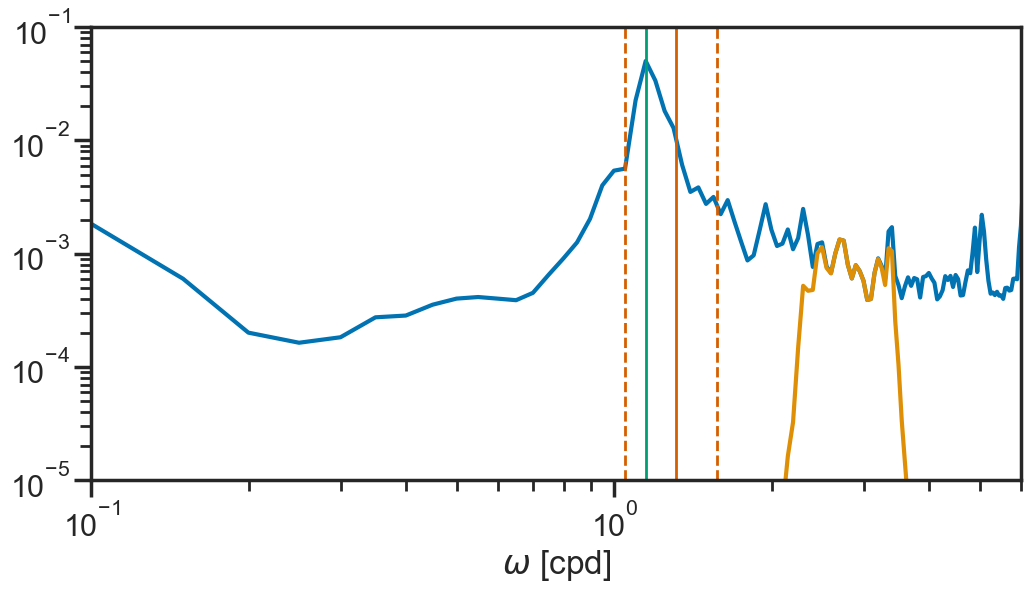

In [1300]:
(dft*dft.frequency).mean('z').plot(label='total')
(dfnit*dfnit.frequency).mean('z').plot(label='bandpass')

plt.axvline(1.15, lw=2, color='g')
plt.axvline(gsw.f(raw.lat.mean())*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.8*gsw.f(raw.lat.mean())*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.2*gsw.f(raw.lat.mean())*86400/(2*np.pi), ls='dashed', lw=2, color='r')


plt.xlim(1e-1,6e0)
plt.ylim(1e-5,1e-1)
plt.title(None);
plt.xlabel('$\omega$ [cpd]')
plt.xscale('log')
plt.yscale('log')

In [1158]:
# integrate energy vertically
raw = raw.swap_dims({'dtime':'time'})
zmin = -300
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['hke_ml_ni'] = ('time', integrate_columns(raw.hkeNI, raw.mld,0))
raw['hke_py_ni'] = ('time', integrate_columns(raw.hkeNI, zmin, raw.mld))
raw['hke_ml'] = ('time', integrate_columns(raw.hkeTOT, raw.mld,0))
raw['hke_py'] = ('time', integrate_columns(raw.hkeTOT, zmin, raw.mld))

In [1159]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['hke_ml_ni'] = raw.hkeNI.where(ml_mask).mean(dim='z')
raw['hke_py_ni'] = raw.hkeNI.where(py_mask).mean(dim='z')
raw['hke_ml'] = raw.hkeTOT.where(ml_mask).mean(dim='z')
raw['hke_py'] = raw.hkeTOT.where(py_mask).mean(dim='z')

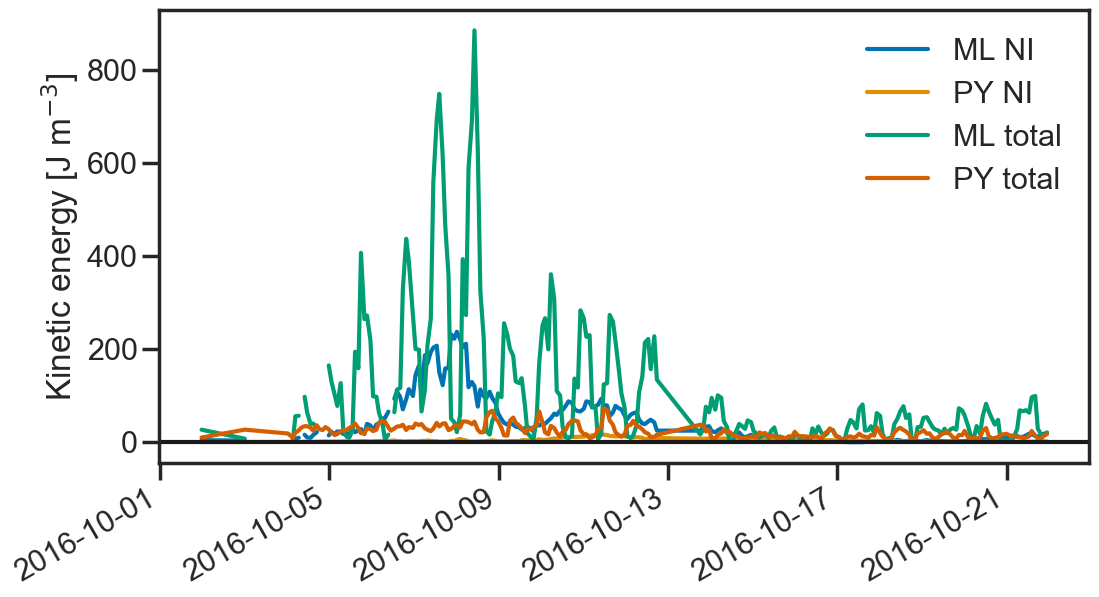

In [1160]:
raw['hke_ml_ni'].plot(label='ML NI')
raw['hke_py_ni'].plot(label='PY NI')
raw['hke_ml'].plot(label='ML total')
raw['hke_py'].plot(label='PY total')
plt.ylabel('Kinetic energy [J m$^{-3}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend();

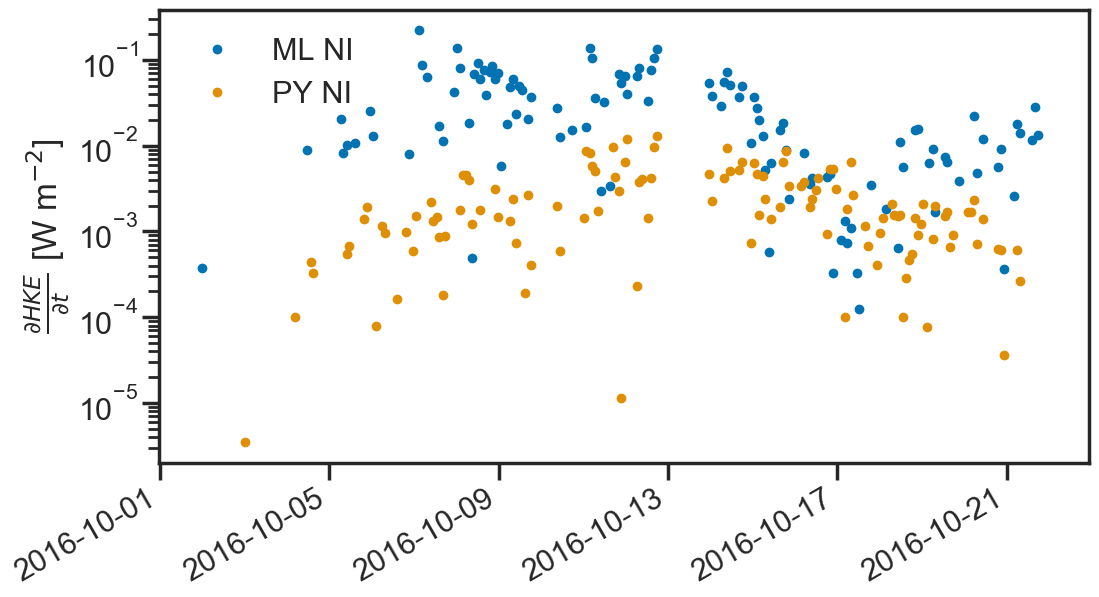

In [1161]:
# take time derivatvies
raw['dhke_ml'] = (raw['hke_ml_ni']*raw.mld).differentiate('time',datetime_unit='s')
raw['dhke_py'] =(raw['hke_py_ni']*raw.mld).differentiate('time',datetime_unit='s')

raw.dhke_ml.plot(label='ML NI', marker='.', lw=0)
raw.dhke_py.plot(label='PY NI', marker='.', lw=0)

# (raw['hke_ml_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='ML NI')
# (raw['hke_py_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='PY NI')
# raw['hke_ml'].differentiate('time',datetime_unit='s').plot(label='ML total')
# raw['hke_py'].differentiate('time',datetime_unit='s').plot(label='PY total')

plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.legend();
plt.yscale('log')

Text(0, 0.5, '$\\frac{\\partial HKE}{\\partial t}_{ML}$ [W m$^{-2}$]')

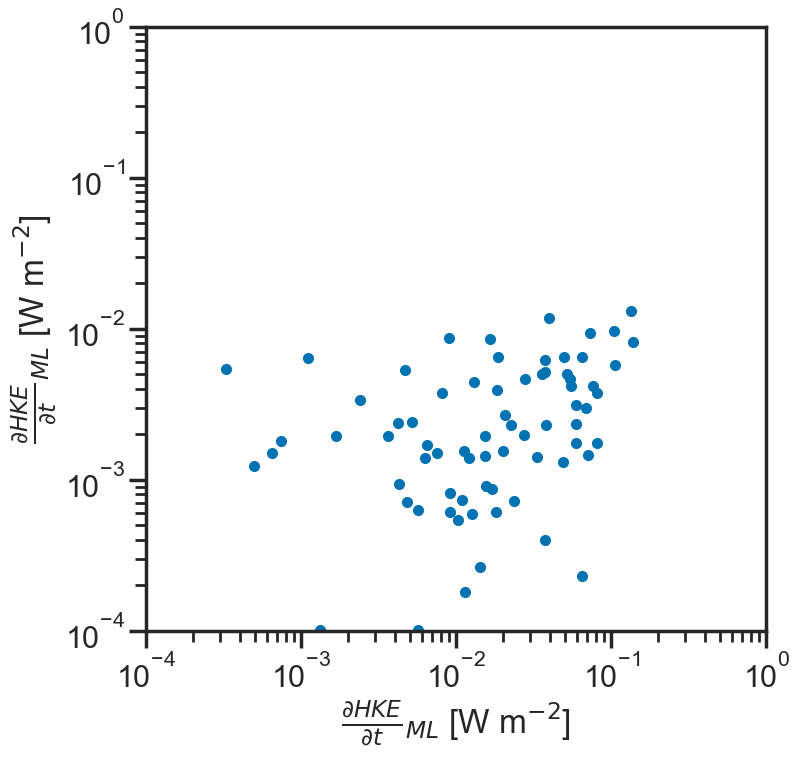

In [1162]:
plt.figure(figsize=(8,8))
plt.scatter(raw.dhke_ml,raw.dhke_py, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\frac{\partial HKE}{\partial t}_{ML}$ [W m$^{-2}$]')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}_{ML}$ [W m$^{-2}$]')

## Wind work $\mathbf{\tau} \cdot \mathbf{u}$

In [407]:
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
cfs = cfs.interp_like(raw).sel(time=slice('2016-10-01','2016-10-21'))

In [408]:
# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0)
indv = first_finite(raw.v, 0)
raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

# extract uppermost velocity measuremnt
indu = first_finite(raw.uNI, 0)
indv = first_finite(raw.vNI, 0)
raw['u_surf_ni'] = raw.uNI[indu]
raw['v_surf_ni'] = raw.vNI[indv]

raw['tx'] = ('time', -cfs['tx'])
raw['ty'] = ('time', -cfs['ty'])
raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty
raw['taudotu_ni'] = raw.u_surf_ni * raw.tx + raw.v_surf_ni * raw.ty
raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))

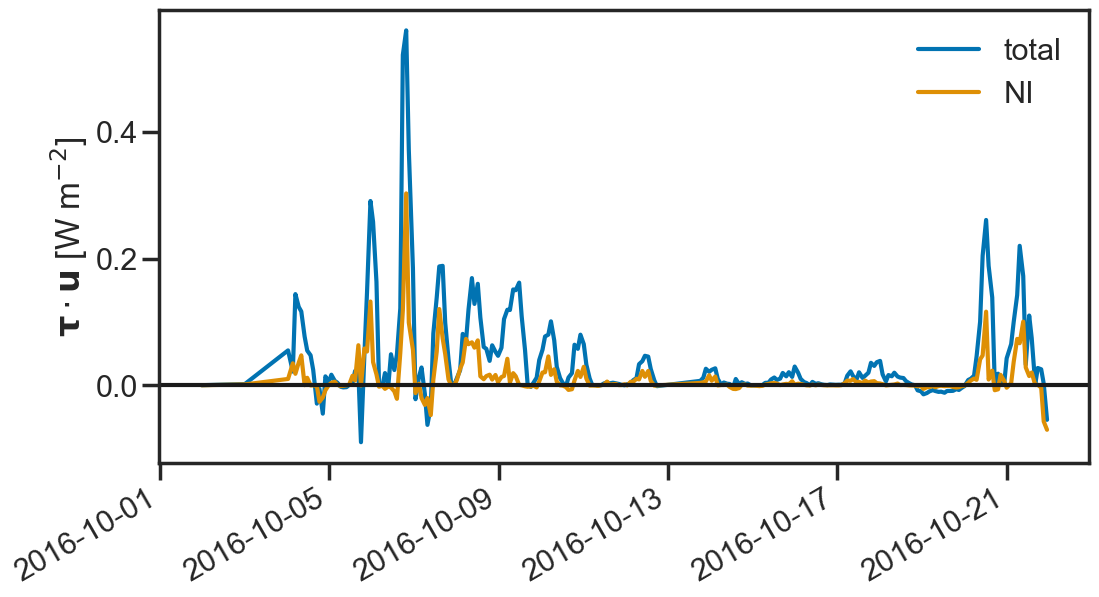

In [435]:
# raw.tau.sel(time=slice('2016-10-01','2016-10-21')).plot(label='tau')
raw.taudotu.plot(label='total')
raw.taudotu_ni.plot(label='NI')
plt.ylabel(r'$\mathbf{\tau} \cdot \mathbf{u}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend()
# plt.yscale('log')

Text(0, 0.5, '$\\frac{\\partial HKE}{\\partial t}_{PY}$ [W m$^{-2}$]')

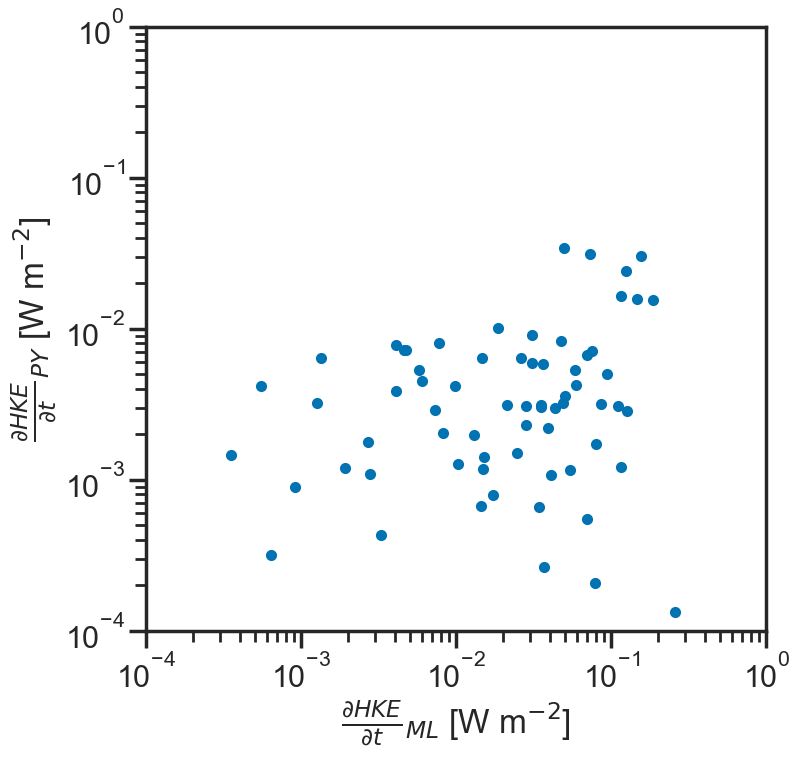

Text(0, 0.5, '$\\frac{\\partial HKE}{\\partial t}$ [W m$^{-2}$]')

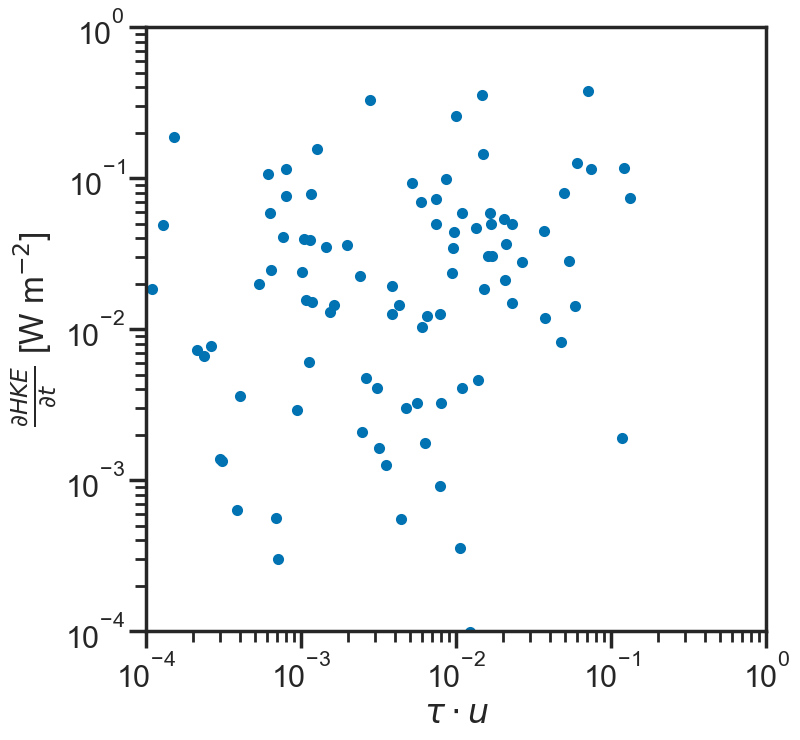

In [436]:
plt.figure(figsize=(8,8))
plt.scatter(raw.taudotu_ni,raw.dhke_ml, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')

## Availabel potential energy (APE)

In [476]:
raw['rho_ref'] = raw.rho0.rolling(time=5, center=True).mean()
raw['rho_prime'] = raw.rho0 - raw.rho_ref

(-200, 0)

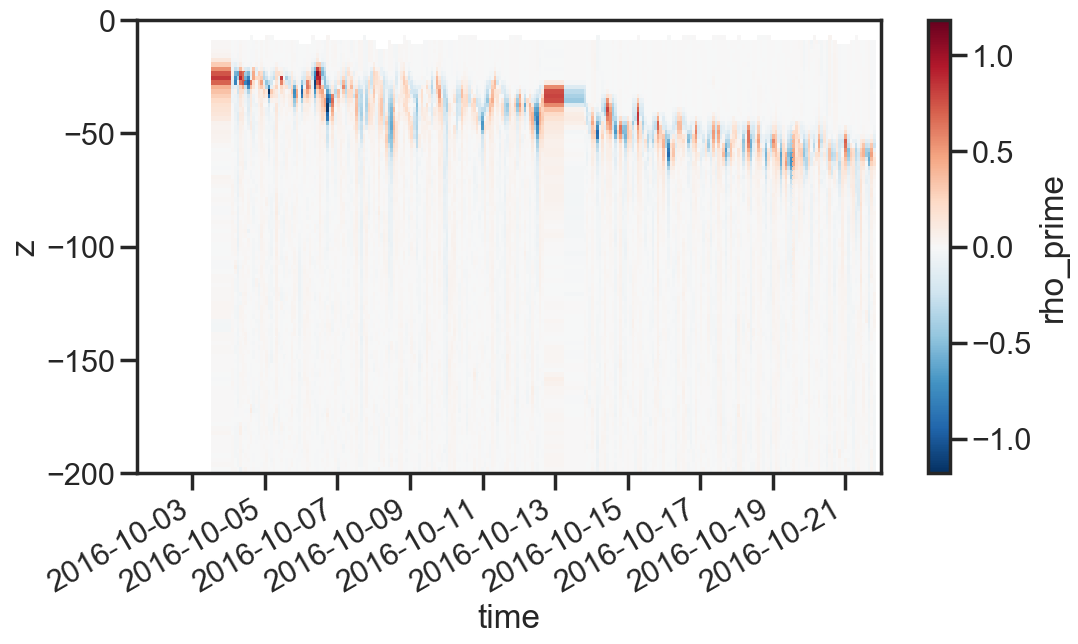

In [584]:
raw.rho_prime.plot()
plt.ylim(-200,0)

In [563]:
array = []
for t in range(raw.time.size):
    # TODO: could do better here with simpson's rule
    prof = raw.isel(time=t)
    prof = prof.dropna(dim='z', how='all', subset=['rho_ref'])
    prof = prof[['rho_ref','rho0','rho_prime']]
    proff = prof.swap_dims({'z':'rho_ref'})
    if prof.rho_ref.size>0:
        prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)
        prof['ape'] = ('z', compute_ape(prof) )
        array.append(prof)
    else:
        array.append(np.nan)
        
cleanedList = [x for x in array if type(x)!=float]
new = xr.concat(cleanedList, dim='time')

In [568]:
raw['ape'] = new.ape.transpose()

(-100, 0)

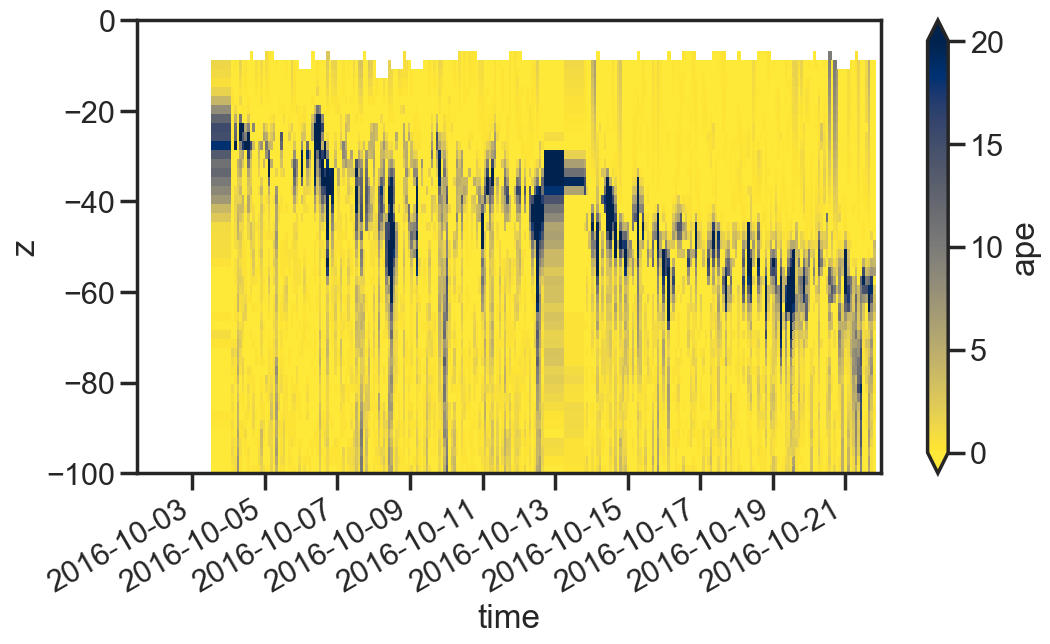

In [585]:
raw.ape.plot(vmin=0, vmax=20, cmap='cividis_r')
plt.ylim(-100,0)

In [587]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['ape_ml'] = raw.ape.where(ml_mask).mean(dim='z')
raw['ape_py'] = raw.ape.where(py_mask).mean(dim='z')

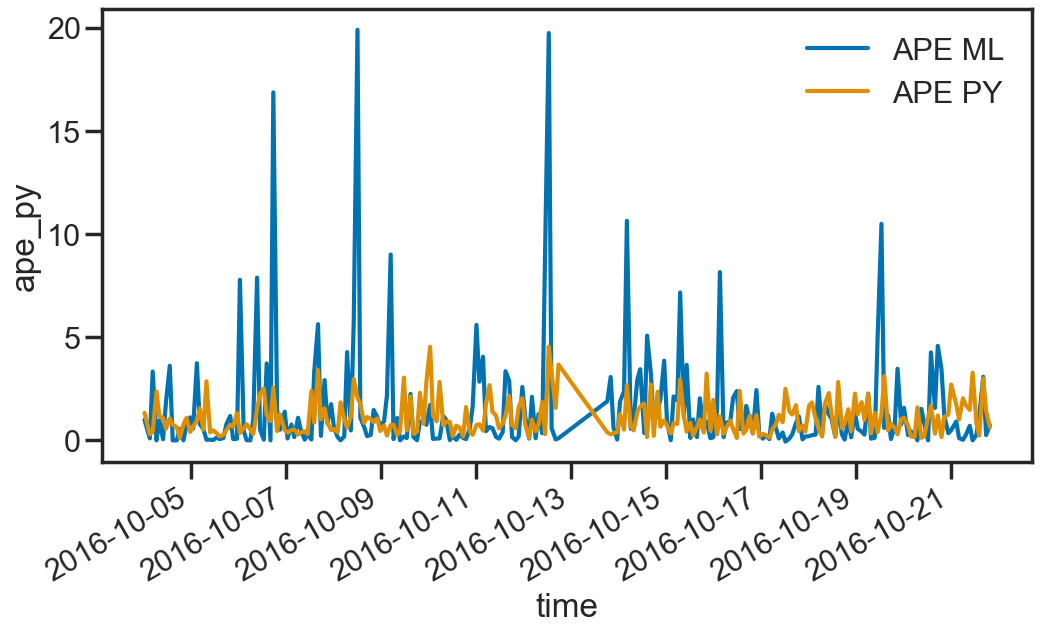

In [591]:
raw.ape_ml.plot(label='APE ML')
raw.ape_py.plot(label='APE PY')
plt.legend()

In [592]:
raw['dape_ml'] = (raw['ape_ml']*raw.mld).differentiate('time',datetime_unit='s')
raw['dape_py'] =(raw['ape_py']*raw.mld).differentiate('time',datetime_unit='s')

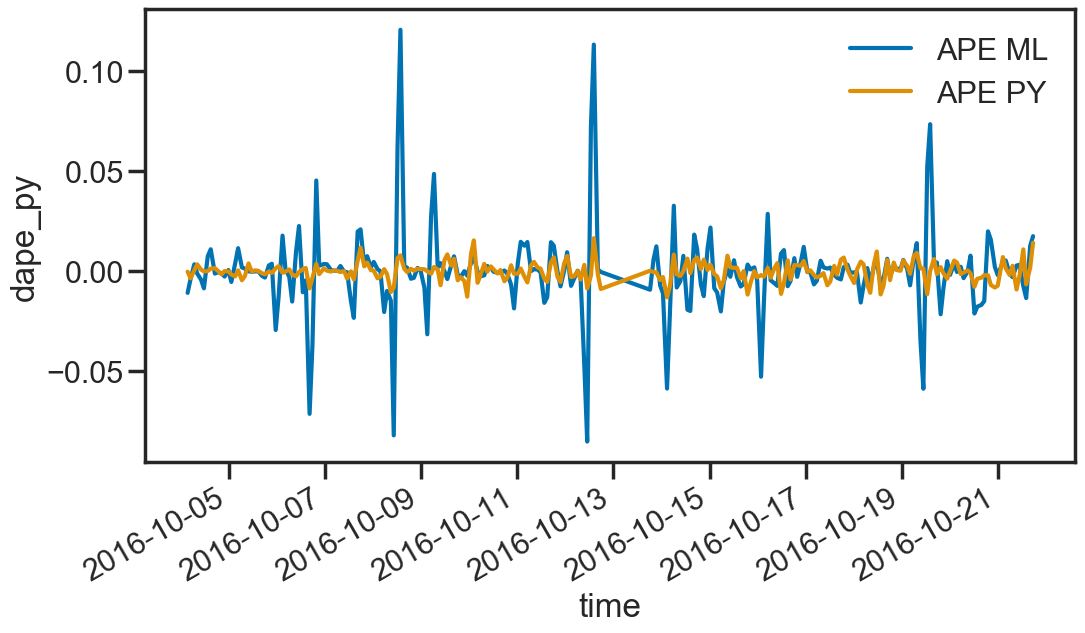

In [593]:
raw.dape_ml.plot(label='APE ML')
raw.dape_py.plot(label='APE PY')
plt.legend()

Text(0, 0.5, '$\\frac{\\partial HKE}{\\partial t}$ [W m$^{-2}$]')

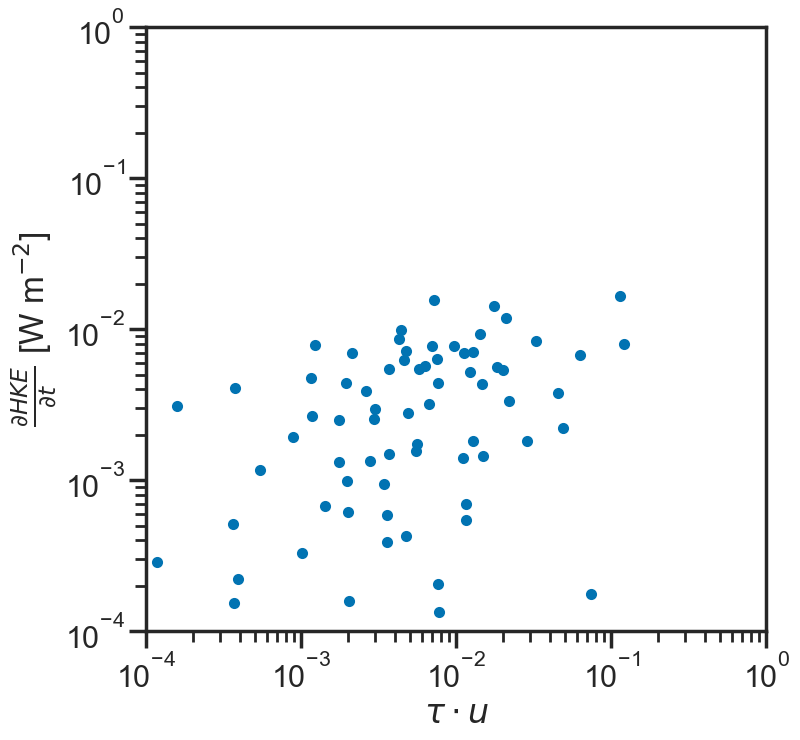

In [685]:
plt.figure(figsize=(8,8))
plt.scatter(raw.dape_ml,raw.dape_py, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')

Text(0, 0.5, '$\\frac{\\partial HKE}{\\partial t}$ [W m$^{-2}$]')

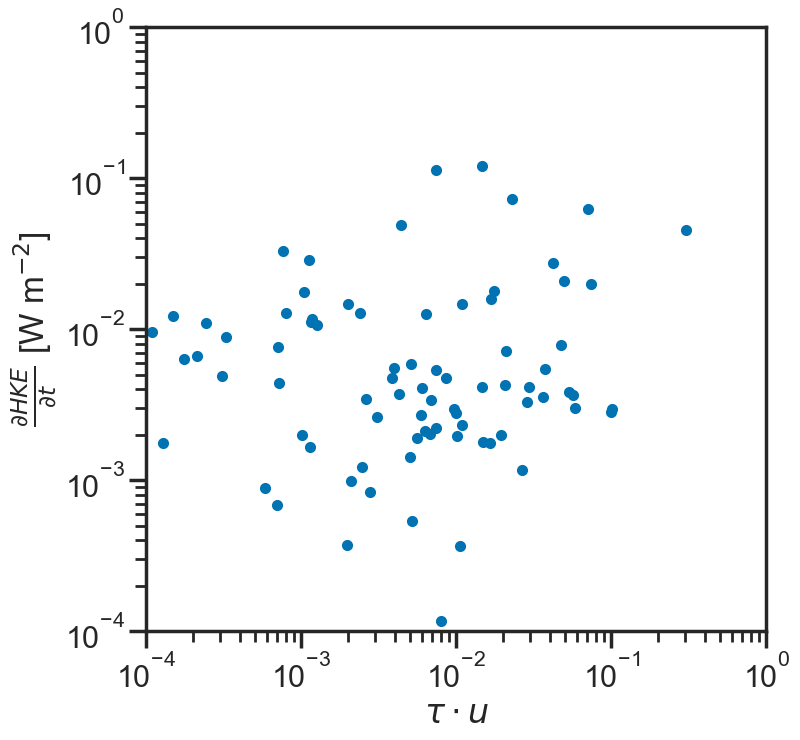

In [604]:
plt.figure(figsize=(8,8))
plt.scatter(raw.taudotu_ni,raw.dape_ml, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')

## Epsilon $\epsilon$

In [594]:
raw = qc_turbulence(raw)

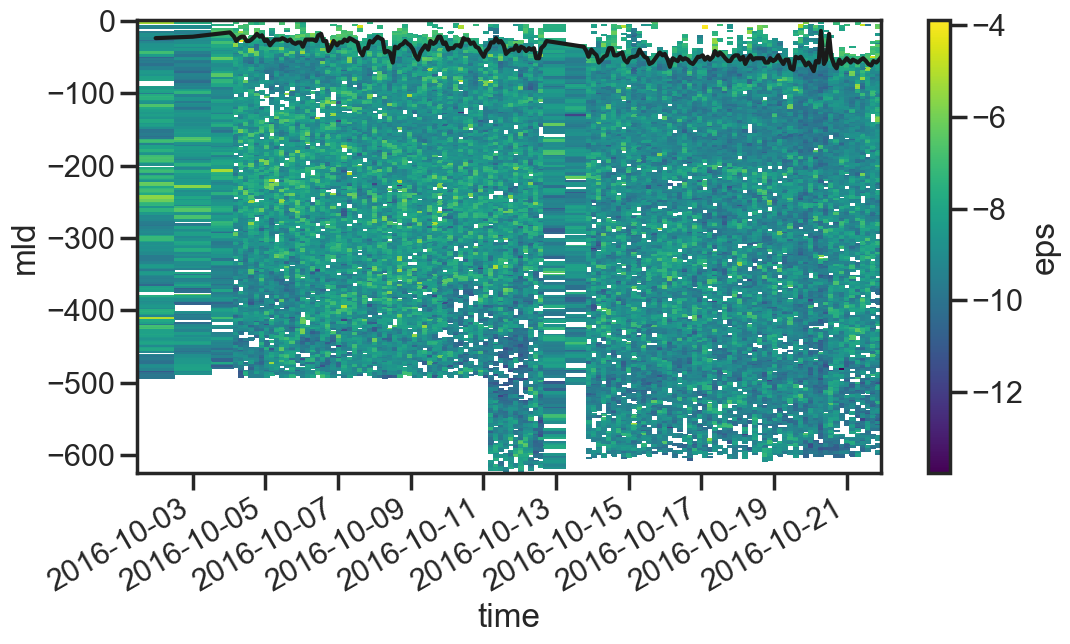

In [618]:
raw.eps.dropna('time', how='all').dropna('z', how='all').pipe(np.log10).plot()
raw.mld.plot(color='k')

In [657]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['eps_ml'] = raw.eps.where(ml_mask).fillna(0).mean(dim='z')
raw['eps_py'] = raw.eps.where(py_mask).fillna(0).mean(dim='z')

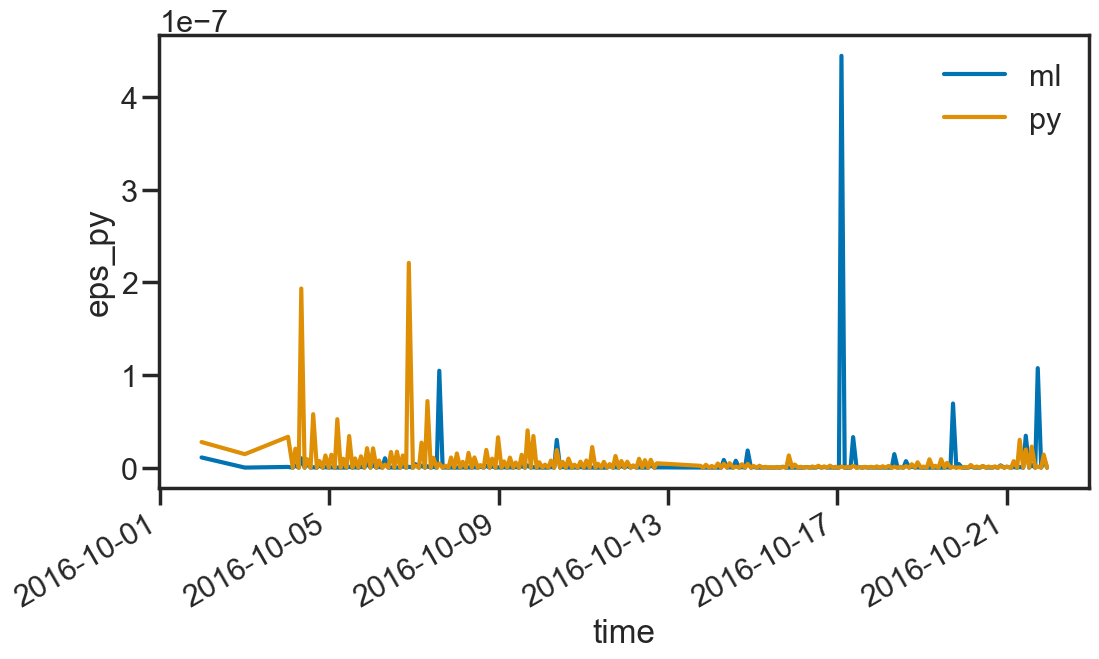

In [658]:
raw['eps_ml'].plot(label='ml')
raw['eps_py'].plot(label='py')
plt.legend();

## Compare all terms togther

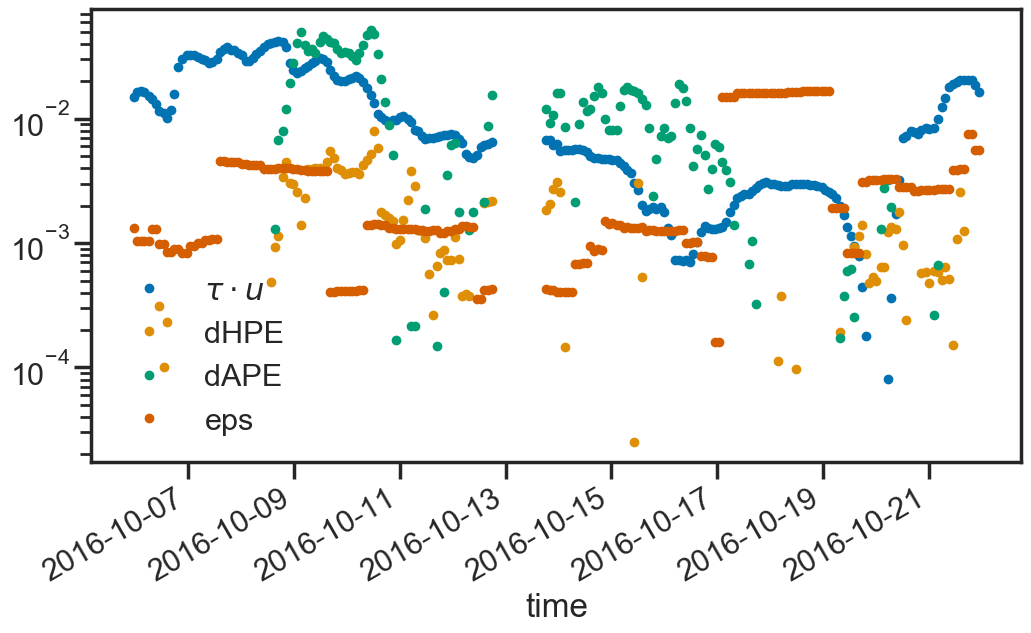

In [677]:
raw.taudotu_ni.rolling(time=30).mean().plot(label=r'$\tau \cdot u$',lw=0, marker='.')
raw.dape_ml.rolling(time=30).mean().plot(label='dHPE',lw=0, marker='.')
raw.dhke_ml.rolling(time=30).mean().plot(label='dAPE',lw=0, marker='.')
raw.eps_ml.rolling(time=30).mean().pipe(lambda x: x*1e6).plot(label='eps',lw=0, marker='.')
plt.legend();
plt.yscale('log')

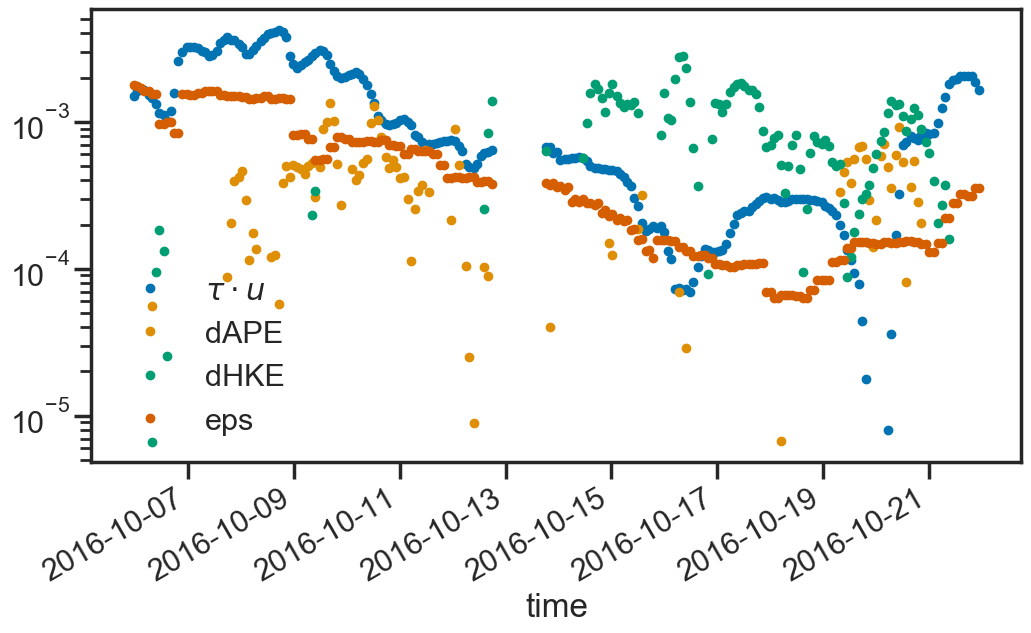

In [678]:
raw.taudotu_ni.rolling(time=30).mean().pipe(lambda x: x/10).plot(label=r'$\tau \cdot u$',lw=0, marker='.')
raw.dape_py.rolling(time=30).mean().plot(label='dAPE',lw=0, marker='.')
raw.dhke_py.rolling(time=30).mean().plot(label='dHKE',lw=0, marker='.')
raw.eps_py.rolling(time=30).mean().pipe(lambda x: x*1e5).plot(label='eps',lw=0, marker='.')
plt.legend()
plt.yscale('log')